In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal
from scipy.signal import butter, filtfilt, find_peaks
import pywt
import warnings
warnings.filterwarnings('ignore')

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

## 原始数据

In [2]:
sampling_rate = 128  # 手腕ppg采样率，Hz
data = np.load(r'D:\D盘\已总结完—数据分析学习总结\20250414整理数据分析面试资料\kaggle\心率检测项目\心率估算-kaggle\24-exercise1\mhealth24_data_public.npy', allow_pickle=True).item() 
phase0_data = data['phase 0']
print('Keys for phase 0:', phase0_data.keys())

ppg_phase0 = phase0_data['PPG wrist']
ref_hr_phase0 = phase0_data['ground truth HR']  # 仅对 for phase 0, 2, ，4 (训练集)
IMU_X_phase0 = phase0_data['IMU X wrist']
IMU_Y_phase0 = phase0_data['IMU Y wrist']
IMU_Z_phase0 = phase0_data['IMU Z wrist']

Keys for phase 0: dict_keys(['ground truth HR', 'PPG wrist', 'IMU X wrist', 'IMU Y wrist', 'IMU Z wrist'])


## 数据处理

In [5]:
class PPGProcessor:
    """PPG信号处理"""
    
    def __init__(self, fs=128):
        """
        初始化处理器
        fs: 采样频率(Hz)
        """
        self.fs = fs

#     使用0.1Hz高通滤波去直流、去除极端基线漂移
    def preprocess_ppg(self, ppg_signal):
        """
        初步预处理：去直流、去除极端基线漂移
        使用0.1Hz高通滤波去除极端基线漂移
        """
        # 1. 去直流
        ppg_dc_removed = ppg_signal - np.mean(ppg_signal)
        
        # 2. 0.1Hz高通滤波去除极端基线漂移
        nyquist = 0.5 * self.fs
        high_cut = 0.1 / nyquist
        
        # 使用二阶巴特沃兹高通滤波器
        b, a = butter(2, high_cut, btype='high')
        ppg_highpassed = filtfilt(b, a, ppg_dc_removed)
        
        return ppg_highpassed
    
    # 预处理加速度计信号
    def preprocess_accel(self, accel_x, accel_y, accel_z):
        """
        预处理加速度计信号
        """
        # 去直流
        accel_x_dc = accel_x - np.mean(accel_x)
        accel_y_dc = accel_y - np.mean(accel_y)
        accel_z_dc = accel_z - np.mean(accel_z)
        
        # 可选的0.5-20Hz带通滤波，保留可能包含运动伪影的频带
        nyquist = 0.5 * self.fs
        low = 0.5 / nyquist
        high = 20.0 / nyquist
        
        b, a = butter(2, [low, high], btype='band')
        accel_x_filt = filtfilt(b, a, accel_x_dc)
        accel_y_filt = filtfilt(b, a, accel_y_dc)
        accel_z_filt = filtfilt(b, a, accel_z_dc)
        
        return accel_x_filt, accel_y_filt, accel_z_filt
    
    # 归一化最小均方(NLMS)自适应滤波器去除运动伪影
    def multi_channel_nlms(self, ppg, accel_x, accel_y, accel_z, filter_order=16, mu=0.005):
        """
        多通道NLMS自适应滤波器
        使用三轴加速度计作为参考信号
        
        Args:
            ppg: PPG信号
            accel_x, accel_y, accel_z: 三轴加速度计信号
            filter_order: 每个通道的滤波器阶数
            mu: 步长参数
            
        Returns:
            filtered_ppg: 去除运动伪影后的PPG信号
        """
        n_samples = len(ppg)
        
        # 确保所有信号长度一致
        ppg = np.asarray(ppg).flatten()
        accel_x = np.asarray(accel_x[:n_samples]).flatten()
        accel_y = np.asarray(accel_y[:n_samples]).flatten()
        accel_z = np.asarray(accel_z[:n_samples]).flatten()
        
        # 组合所有参考信号
        references = [accel_x, accel_y, accel_z]
        n_refs = len(references)
        
        # 初始化
        weights = np.zeros((n_refs, filter_order))  # 每个参考信号一个滤波器
        filtered_ppg = ppg.copy()
        
        # 为每个参考信号创建缓冲区
        x_buffers = [np.zeros(filter_order) for _ in range(n_refs)]
        
        # 多通道NLMS算法
        for n in range(n_samples):
            # 更新所有参考信号的缓冲区
            for i in range(n_refs):
                x_buffers[i][1:] = x_buffers[i][:-1]
                x_buffers[i][0] = references[i][n]
            
            # 计算所有滤波器的输出总和（估计的总噪声）
            estimated_noise = 0
            input_power_total = 0
            
            for i in range(n_refs):
                # 计算该通道的滤波器输出
                channel_output = np.dot(weights[i], x_buffers[i])
                estimated_noise += channel_output
                input_power_total += np.dot(x_buffers[i], x_buffers[i])
            
            # 计算误差
            e_n = ppg[n] - estimated_noise
            
            # 更新所有滤波器的权重
            for i in range(n_refs):
                input_power = np.dot(x_buffers[i], x_buffers[i]) + 1e-10
                weights[i] = weights[i] + (mu * e_n / input_power) * x_buffers[i]
            
            # 存储滤波后的信号
            filtered_ppg[n] = e_n
        
        return filtered_ppg
    
    # 巴特沃斯带通滤波器
    def butter_bandpass_filter(self, data, lowcut=0.5, highcut=4.0, order=4): # 0.5~5Hz的带通滤波
        """
        巴特沃斯带通滤波器
        """
        nyquist = 0.5 * self.fs
        low = lowcut / nyquist
        high = highcut / nyquist
        b, a = butter(order, [low, high], btype='band')
        y = filtfilt(b, a, data)  # 双向滤波避免相位失真
        return y
    
    # 去除基线漂移
    def remove_baseline_wander(self, data, cutoff=0.5): # 0.5以上 高通滤波
        """
        去除基线漂移
        """
        nyquist = 0.5 * self.fs
        normal_cutoff = cutoff / nyquist
        b, a = butter(4, normal_cutoff, btype='high')
        y = filtfilt(b, a, data)
        return y
    
    #   移动平均滤波
    def moving_average(self, data, window_size=5):
        """
        移动平均滤波
        """
        # 根据采样率调整窗口大小
#         sampling_rate = 128  # Hz
#         window_seconds = 1  # 1.5秒窗口
#         window_size = int(window_seconds * sampling_rate)  # 150点
        
        window = np.ones(window_size) / window_size
        y = np.convolve(data, window, mode='same')
        return y
    
    # 自适应峰值检测
    def adaptive_peak_detection(self, data, min_distance=None):
        """
        自适应峰值检测
        """
        if min_distance is None:
            min_distance = int(0.4 * self.fs)  # 最小间隔0.5秒，函数中默认使用0.5秒，即对应120 bpm，这是一个常见的静息心率上限。
            # 这个参数控制 预测心率值的大小，太小预测心率就太大，太大预测心率就太小
        
        # 计算动态阈值
#         data_median = np.median(data)
        threshold = 0.5 * np.std(data)
        
        # 寻找峰值
        peaks, properties = find_peaks(
            data, 
            height=threshold, # 峰值的最低高度
            distance=min_distance, # 相邻峰值之间的最小水平距离，
            prominence=0.05 * np.std(data) # 峰值的显著性，即峰值相对于周围谷地的垂直距离，排除非显著峰值（如小波动）非常有用，
#             ,width=(6, 50) # 表示只选择那些宽度在6到50个采样点之间的峰值。注意：这里的宽度是指峰值在其高度一半处的宽度（也称为半高宽）。具体来说，对于每个峰值，函数会计算峰值高度一半处的水平线与峰值两侧交点的距离。
#             ,width=(20, 50)
            ,width=12
        )
        
        return peaks
    
    # 计算心率
    def calculate_heart_rate(self, peaks, window_size=10):
        """
        计算心率
        """
        if len(peaks) < 2:
            return None
        
        # 计算RR间期（秒）
        rr_intervals = np.diff(peaks) / self.fs
        
        # 转换为BPM
        heart_rates = 60 / rr_intervals
        
        # 异常值过滤（心率在30-240BPM之间）
        valid_idx = (heart_rates > 30) & (heart_rates < 240)
        heart_rates = heart_rates[valid_idx]
        
        if len(heart_rates) == 0:
            return None
        
#         heart_rate = np.mean(heart_rates)
        heart_rate = np.median(heart_rates) # 使用中位数
    
        return heart_rate, heart_rates, rr_intervals

    # 完整的PPG处理流程
    def process_pipeline(self, ppg_signal, visualize=False):
        """
        完整的PPG处理流程
        """
        
        # 步骤0.1: 使用0.1Hz高通滤波去直流、去除极端基线漂移
        filtered_ori = self.preprocess_ppg(ppg_signal)
    
        # 步骤0.2: 预处理加速度计信号
        accel_X_filt, accel_Y_filt, accel_Z_filt = self.preprocess_accel(IMU_X_phase0,IMU_Y_phase0,IMU_Z_phase0)
        
        # 步骤0.3: 归一化最小均方(NLMS)自适应滤波器去除运动伪影
        ppg_motion_removed = self.multi_channel_nlms(filtered_ori,accel_X_filt, accel_Y_filt, accel_Z_filt, filter_order=46, mu=0.001)
#         ppg_motion_removed = self.adaptive_filter_nlms(filtered_ori, [], filter_order=16, mu=0.005)
        
        # 步骤1: 带通滤波 (0.5-4 Hz)
        filtered = self.butter_bandpass_filter(ppg_motion_removed, lowcut=0.5, highcut=5.0, order=3)
        
        # 步骤3: 基线漂移去除
        baseline_removed = self.remove_baseline_wander(filtered, cutoff=0.5)
        
        # 步骤4: 移动平均平滑
        smoothed = self.moving_average(baseline_removed, window_size=5)
    
        # 3. 归一化
        normalized = (smoothed - np.min(smoothed)) / (np.max(smoothed) - np.min(smoothed))
        
        # 步骤5: 峰值检测
        peaks = self.adaptive_peak_detection(normalized)
        
        # 步骤6: 心率计算
        result = self.calculate_heart_rate(peaks)
        
        if result is not None:
            heart_rate, heart_rates, rr_intervals = result
#             print(f"计算心率: {heart_rate:.1f} BPM")
#             print(f"检测到心跳次数: {len(peaks)}")
#             print(f"平均RR间期: {np.mean(rr_intervals):.3f} 秒")
        else:
            heart_rate = None
            heart_rates = []
            rr_intervals = []
            print("心率计算失败")
        
        return {
            'heart_rate': heart_rate,
            'peaks': peaks,
            'heart_rates': heart_rates,
            'rr_intervals': rr_intervals,
            'processed_signal': smoothed
        }

## 结果

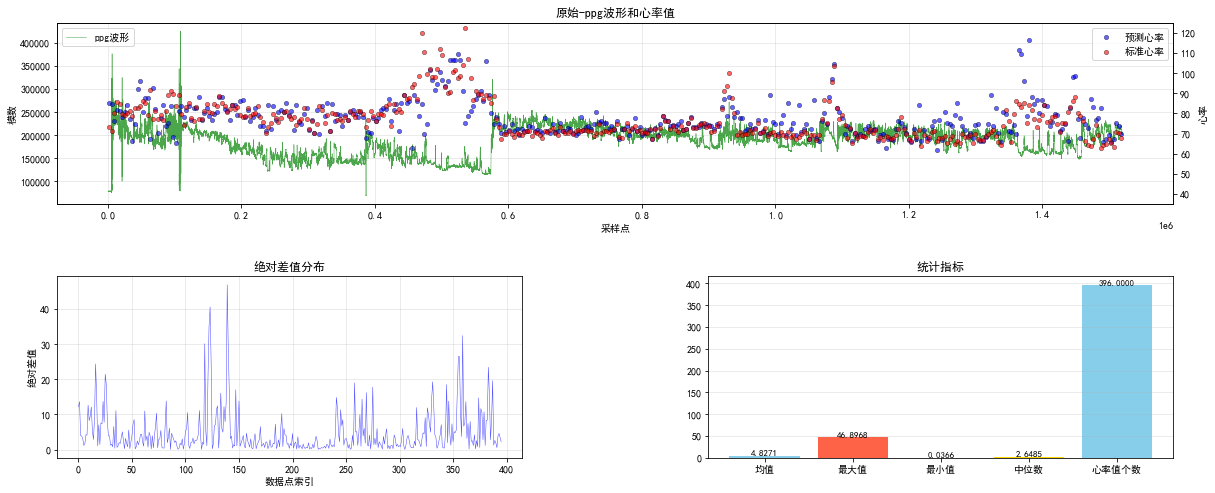

均值: 4.8271
最大值: 46.8968
最小值: 0.0366
中位数: 2.6485
心率值个数: 396.0000


In [6]:
# 主程序
if __name__ == "__main__":
    processor = PPGProcessor(fs=128)
    id_ori = []
    hr_ori = []
    ref_hr = []
    n = 0
    # 以30s为一段进行计算
    for i in range(0, len(ppg_phase0), 128*30):
        noisy_ppg = ppg_phase0[i:i+128*30]
        results = processor.process_pipeline(noisy_ppg, visualize=False)
        if results['heart_rate'] is None:
            n = n + 1
            continue
        id_ori.append(i+1920)  # 以每段中间作为心率中位数的时间点
        hr_ori.append(results['heart_rate'] )
        ref_hr.append(ref_hr_phase0[n])
        n = n + 1

    # 评价指标
    data_ori = ppg_phase0.copy()
    list0 = id_ori.copy()
    list1 = hr_ori.copy()
    list2 = ref_hr.copy()
    # 计算绝对差值和统计指标
    abs_diff = np.abs(np.array(list1) - np.array(list2))
    stats = [np.mean(abs_diff), np.max(abs_diff), np.min(abs_diff), np.median(abs_diff),len(list0)]
    labels = ['均值', '最大值', '最小值', '中位数','心率值个数']

    
    fig = plt.figure(figsize=(20, 8))

    # 定义网格：2行2列，设置高度和宽度比例
    gs = gridspec.GridSpec(2, 2, 
                           height_ratios=[1, 1],  # 第一行高度是第二行的2倍
                           width_ratios=[1, 1],   # 列宽度相同
                           hspace=0.4, wspace=0.4)  # 子图间距

    # 第一行大图：占用第一行两列
    ax1 = fig.add_subplot(gs[0, :])

    # 第二行两个小图
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])

    # 在第一行绘制
    ax1.plot(data_ori, 'g-', alpha=0.7, linewidth=0.5, label='ppg波形')
    # ax1.set_title(f'原始-ppg波形和心率值-{heart_rate:.0f}')  # 无小数
    ax1.set_title('原始-ppg波形和心率值' ) 
    ax1.set_xlabel('采样点')
    ax1.set_ylabel('模数')

    ax1_right1 = ax1.twinx()
    ax1_right1.scatter(list0, list1, alpha=0.6, s=20, c='blue', edgecolors='black', linewidth=0.5, label='预测心率')
    ax1_right1.scatter(list0, list2, alpha=0.6, s=20, c='red', edgecolors='black', linewidth=0.5, label='标准心率')
    ax1_right1.set_ylabel('心率')
    ax1_right1.set_ylim(35, 125)

    ax1.legend(loc='upper left')  # 自动选择最佳位置
    ax1_right1.legend(loc='upper right') 
    ax1.grid(True, alpha=0.3)

    # 左图: 绝对差值折线
    ax2.plot(abs_diff, 'b-', alpha=0.7, linewidth=0.5)
    ax2.set_xlabel('数据点索引')
    ax2.set_ylabel('绝对差值')
    ax2.set_title('绝对差值分布')
    ax2.grid(True, alpha=0.3)

    # 右图: 统计指标
    bars = ax3.bar(labels, stats, color=['skyblue', 'tomato', 'limegreen', 'gold'])
    ax3.set_title('统计指标')
    ax3.grid(True, alpha=0.3, axis='y')

    # 添加数值标签
    for bar, value in zip(bars, stats):
        ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                  f'{value:.4f}', ha='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    # 输出结果
    for label, value in zip(labels, stats):
        print(f"{label}: {value:.4f}")    

## ppg数据缩放查看

In [1]:
# 缩放数据查看
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

def plot_signal_interactive_full(signal, title, ylabel, sampling_rate=128, 
                                 show_range_slider=True, show_modebar=True):
    """
    完整的交互式信号绘图函数
    
    参数:
    - show_range_slider: 是否显示范围滑块
    - show_modebar: 是否显示模式栏（缩放、保存等按钮）
    """
    # 创建时间轴
    time_seconds = np.arange(len(signal)) / sampling_rate
    time_min_sec = [f"{int(t//60)}:{t%60:05.2f}" for t in time_seconds]
    
    # 创建图表
    fig = go.Figure()
    
    fig.add_trace(go.Scatter(
        x=time_seconds,
        y=signal,
        mode='lines',
        name=ylabel,
        line=dict(color='blue', width=2),
        hovertemplate=(
            '<b>时间</b>: %{customdata}<br>' +
            '<b>秒数</b>: %{x:.3f}s<br>' +
            f'<b>{ylabel}</b>: %{{y:.4f}}<br>' +
            '<extra></extra>'
        ),
        customdata=time_min_sec
    ))
    
    # 设置布局
    fig.update_layout(
        title={
            'text': f'<b>{title}</b>',
            'x': 0.5,
            'xanchor': 'center',
            'font': {'size': 20}
        },
        xaxis_title="Time (seconds)",
        yaxis_title=ylabel,
        hovermode='x unified',
        template='plotly_white',
        height=500,
        width=900,
        margin=dict(l=50, r=50, t=80, b=50)
    )
    
    # 添加范围滑块
    if show_range_slider:
        fig.update_layout(
            xaxis=dict(
                rangeslider=dict(
                    visible=True,
                    thickness=0.05,
                    bgcolor="lightgray"
                ),
                range=[0, min(30, len(signal)/sampling_rate)]  # 默认显示前30秒
            )
        )
    
    # 显示图表
    fig.show(config={
        'modeBarButtonsToAdd': ['drawline', 'drawopenpath', 'eraseshape'],
        'displayModeBar': show_modebar,
        'scrollZoom': True
    })
    
    return fig


fig = plot_signal_interactive_full(
    ppg_phase0,
    'PPG信号 - 手腕',
    '幅度 (a.u.)',
    sampling_rate=128
)
